# Allenamento baseline ResNet50 per Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD**
3. **Inizializza PoseEstimatorBaseline** (ResNet-50 backbone, solo rotazione)
4. **Training**
5. **Valutazione su test set** (solo metriche di rotazione)

## 1. Import e Setup

In [1]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm import tqdm


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import show_pose_samples, plot_training_validation_loss_from_csv, show_pose_samples_with_add
from utils.training import train_pose_baseline
from utils.losses import PoseLossBaseline
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_rotation_only, load_all_models, load_models_info
from models.pose_estimator_baseline import PoseEstimatorBaseline

Cache Strategy: full


## 2. Carica dataset LineMOD

In [2]:
# Carica i dataloader train, val e test
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


### 2.1 Visualizza immagini training set con info su rotazione

In [ ]:
# Visualizza alcuni sample del dataset (le immagini sono già croppate)

batch = next(iter(train_loader))
show_pose_samples(batch, n=4)

## 3. Inizializza Modello PoseEstimatorBaseline

In [3]:
# Inizializza il modello baseline per la sola rotazione (ResNet-50)
model = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

# Mostra info minimali sul modello
params_info = model.get_num_parameters()
print(f"Modello PoseEstimatorBaseline caricato su: {Config.DEVICE}")
print(f"Parametri totali: {params_info['total']:,}")
print(f"Parametri allenabili: {params_info['trainable']:,}")

PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5
Modello PoseEstimatorBaseline caricato su: mps
Parametri totali: 26,136,132
Parametri allenabili: 26,136,132


## 4. Nome e path per allenare-caricare un modello

In [4]:
# Parametri utili anche quando non si fa training
NAME = "test_rotationonly_1"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training (solo rotazione)

In [ ]:
# Training baseline rotazione (PoseLossBaseline)
EPOCHS = 5#Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Salva args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
# Assicurati che la directory esista prima di salvare il file
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLossBaseline()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history, best_loss, best_epoch = train_pose_baseline(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)

print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completato!")

### 5.1 Visualizzazione loss

In [ ]:
# Plotta la curva di training loss dal CSV
results_path = checkpoint_dir / 'results.csv'
plot_training_validation_loss_from_csv(results_path)

## 6. Test e Valutazione su sample del Test Set (solo rotazione)

### 6.1 Visualizza predizione su batch immagini

✅ Modello test_rotationonly_1 caricato e in modalità eval!
Batch casuale: estrazione batch random dal dataset di test
Indice di inizio batch casuale: 9283
Numero di sample estratti: 64
Chiavi batch: ['rgb_crop', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'info_path']

Conversione quaternioni in matrici di rotazione
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points

Calcolo metrica ADD
Test completato su 64 sample

📊 ADD medio sul batch:
   Mean ADD: 21.8723 ± 8.5089


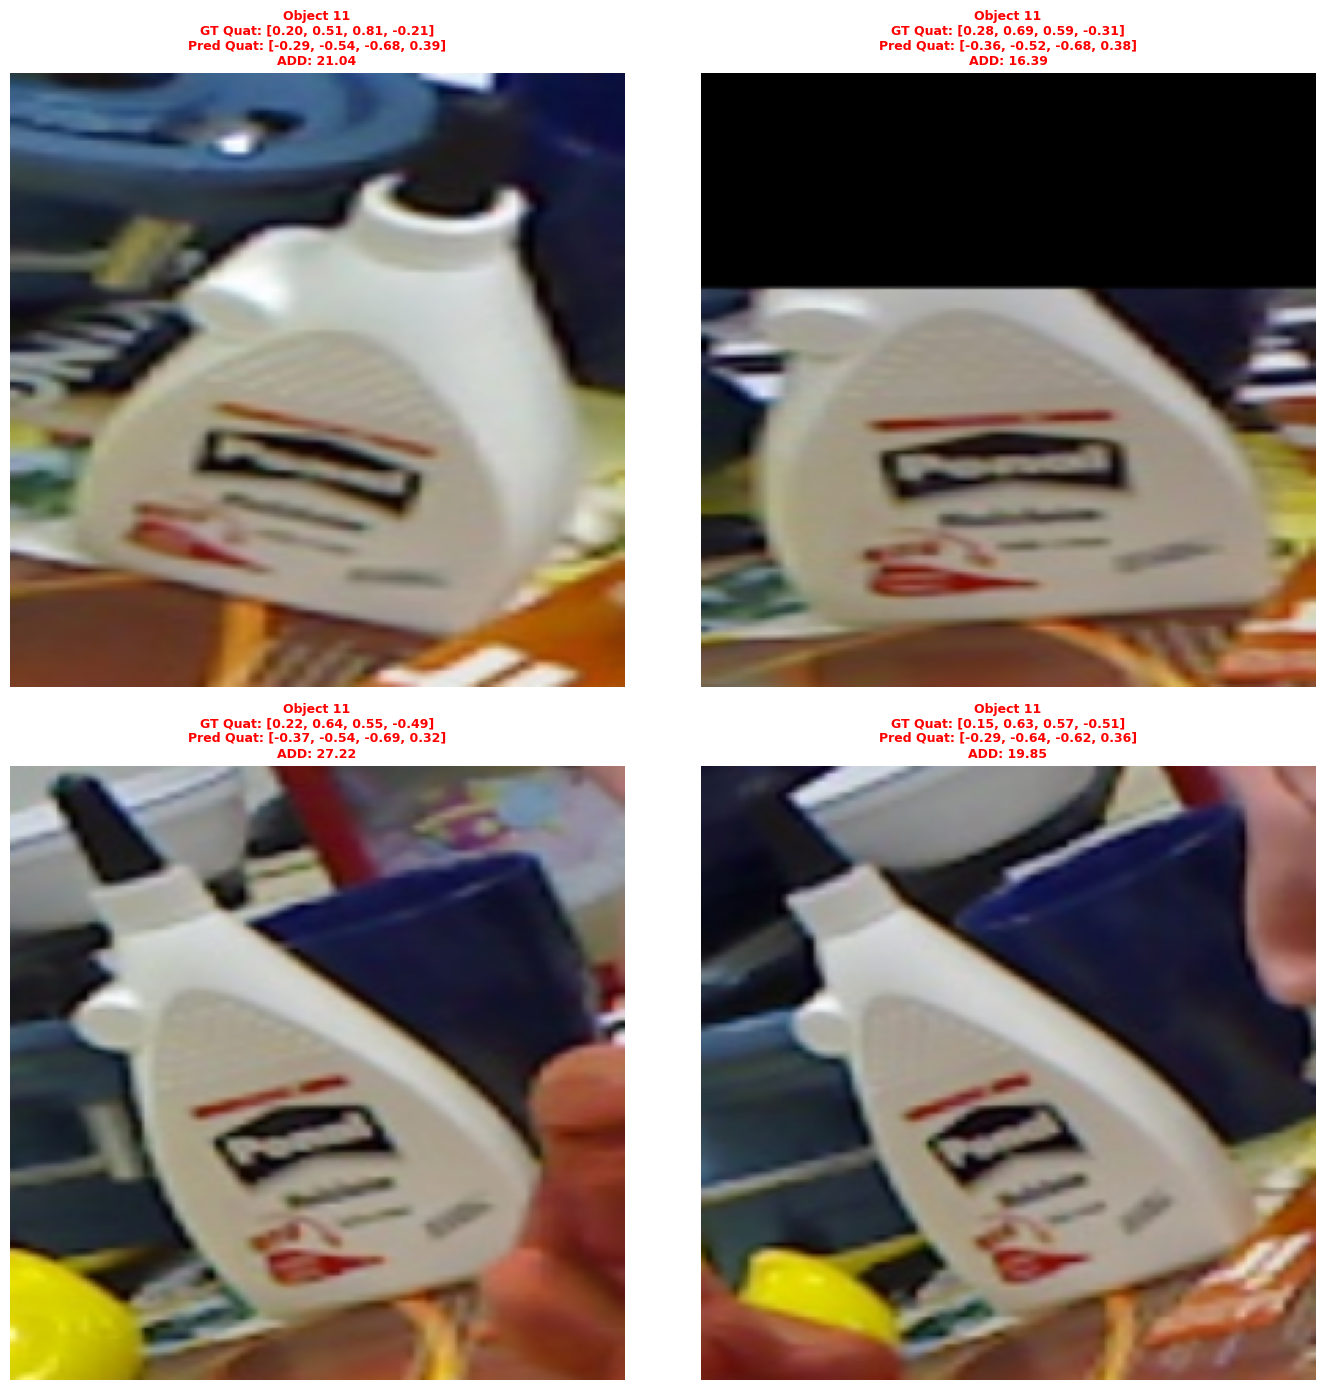

In [5]:
NAME = "test_rotationonly_1"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

# Carica il modello trained (se necessario)
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello {NAME} caricato e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")

# Estrai un batch casuale direttamente dal dataset di test
print("Batch casuale: estrazione batch random dal dataset di test")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Indice di inizio batch casuale: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # lista indici selezionati
samples = [test_loader.dataset[i] for i in indices]
print(f"Numero di sample estratti: {len(samples)}")

# Collate i sample come fa il DataLoader
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values
print(f"Chiavi batch: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions = model(images)

# Conversione quaternioni in matrici di rotazione
print("\nConversione quaternioni in matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Calcola la metrica ADD solo rotazione (usa utils.metrics)
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")

print("\nCalcolo metrica ADD")
results = compute_add_batch_rotation_only(pred_R, gt_R, obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)

rot_errors = results.get('add_values', None)
print(f"Test completato su {len(images)} sample")
print(f"\n📊 ADD medio sul batch:")
print(f"   Mean ADD: {np.mean(rot_errors):.4f} ± {np.std(rot_errors):.4f}")

# Visualizza 4 sample con errore di rotazione
show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_errors)

### 6.2 Statistiche su intero Test set

In [ ]:
# Calcola le metriche di rotazione (con il modello) e di traslazione (con pinhole) su tutto il test set e salva i risultati in 'results'

# Carica i modelli 3D e info oggetti
models_dict = load_all_models()
models_info = load_models_info(Config.MODELS_INFO_PATH)

from utils.pinhole import compute_translation_pinhole, load_camera_intrinsics

all_pred_quaternions = []
all_gt_quaternions = []
all_obj_ids = []
all_pinhole_errors = []

missing_batches = []

for i, batch in enumerate(tqdm(test_loader, desc="Valutazione su test set")):
    images = batch['rgb_crop'].to(Config.DEVICE)
    gt_quaternions = batch['quaternion'].to(Config.DEVICE)
    obj_ids = batch['obj_id'].to(Config.DEVICE) if isinstance(batch['obj_id'], torch.Tensor) else torch.tensor(batch['obj_id'], device=Config.DEVICE)
    # Predizione rotazione con il modello
    with torch.no_grad():
        pred_quaternions = model(images)
    all_pred_quaternions.append(pred_quaternions)
    all_gt_quaternions.append(gt_quaternions)
    all_obj_ids.append(obj_ids)
    # Calcolo errore pinhole per ogni sample del batch (rimane su CPU perché usa numpy e funzioni esterne)
    bboxes = batch.get('bbox', None)
    depth_paths = batch.get('depth_path', None)
    info_paths = batch.get('info_path', None)
    if bboxes is None or depth_paths is None or info_paths is None:
        missing_batches.append(i)
        raise RuntimeError(f"Batch {i}: manca almeno uno tra bbox, depth_path, info_path. Impossibile calcolare la traslazione pinhole.")
    pinhole_batch = []
    for bbox, depth_path, info_path, obj_id in zip(bboxes, depth_paths, info_paths, obj_ids.cpu().numpy()):
        try:
            intrinsics = load_camera_intrinsics(info_path)
            pred_translation = compute_translation_pinhole(bbox, depth_path, intrinsics)
            # Se hai la gt, puoi calcolare l'errore rispetto alla gt (qui esempio placeholder)
            if 'gt_translation' in batch:
                gt_translation = batch['gt_translation']
                err = np.linalg.norm(pred_translation - gt_translation)
            else:
                err = np.linalg.norm(pred_translation)
            pinhole_batch.append(err)
        except Exception as e:
            print(f"Errore pinhole per obj_id {obj_id}: {e}")
            raise RuntimeError(f"Errore pinhole per obj_id {obj_id}: {e}")
    all_pinhole_errors.append(np.array(pinhole_batch))

# Concatena tutti i batch su DEVICE finché possibile
all_pred_quaternions = torch.cat(all_pred_quaternions, dim=0)
all_gt_quaternions = torch.cat(all_gt_quaternions, dim=0)
all_obj_ids = torch.cat(all_obj_ids, dim=0)

# Converti quaternioni in matrici di rotazione (su DEVICE)
pred_R = quaternion_to_rotation_matrix_batch(all_pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(all_gt_quaternions)

# Porta obj_ids su CPU solo per le metriche che richiedono numpy
obj_ids_np = all_obj_ids.cpu().numpy()

# Calcola le metriche SOLO ROTAZIONE
results = compute_add_batch_rotation_only(pred_R, gt_R, obj_ids_np, models_dict, models_info)
results['obj_ids'] = obj_ids_np
if all_pinhole_errors:
    all_pinhole_errors = np.concatenate(all_pinhole_errors, axis=0)
    results['pinhole_errors'] = all_pinhole_errors
print("✅ Calcolate metriche di rotazione (modello) e traslazione (pinhole) su tutto il test set. Pronto per tabella e grafico.")

if missing_batches:
    print(f"Attenzione: batches senza dati pinhole: {missing_batches}")

Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Valutazione su test set:   1%|▏         | 3/210 [00:53<1:01:15, 17.75s/it]


KeyboardInterrupt: 

### 6.3 Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [ ]:
# Calcola e mostra la tabella delle performance per classe
results = globals().get('results', None)
if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    is_correct = np.array(results['is_correct'])
    data = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        mean_add = add_values[mask].mean()
        acc = is_correct[mask].mean() * 100
        data.append({
            'Classe': f"{obj_id:02d} - {obj_name.get('name')}",
            'Media ADD (Rotation Only)': f"{mean_add:.2f}",
            'Accuracy (%)': f"{acc:.1f}"
        })
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD:", f"{add_values.mean():.2f}")
    print("Accuracy globale (%):", f"{is_correct.mean()*100:.1f}")

In [ ]:
# --- Tabella errore Pinhole per classe (se disponibile) ---
import os

# Path del file CSV dei risultati pinhole (modifica se necessario)
pinhole_results_path = os.path.join(str(Config.CHECKPOINT_DIR), "pose", NAME, "results.csv")

if os.path.exists(pinhole_results_path):
    pinhole_df = pd.read_csv(pinhole_results_path)
    # Cerca colonne che rappresentano errore pinhole per classe
    pinhole_cols = [c for c in pinhole_df.columns if "pinhole" in c.lower() or "err" in c.lower()]
    if len(pinhole_cols) > 0:
        # Mostra solo le colonne rilevanti
        display(pinhole_df[[c for c in pinhole_df.columns if c.lower().startswith("classe") or c in pinhole_cols]])
        # Calcola e mostra la media globale se presente
        if any("globale" in c.lower() for c in pinhole_df.columns):
            global_col = [c for c in pinhole_df.columns if "globale" in c.lower()][0]
            print(f"\n{global_col}: {pinhole_df[global_col].iloc[0]:.2f}")
    else:
        print("⚠️  Nessuna colonna di errore pinhole trovata nel CSV.")
else:
    print(f"⚠️  File risultati pinhole non trovato: {pinhole_results_path}")


### 6.4 Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

In [ ]:
# Grafico a barre delle medie ADD per classe
from matplotlib import pyplot as plt


if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    class_names = []
    mean_adds = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        class_names.append(f"{obj_id:02d} - {obj_name.get('name')}")
        mean_adds.append(add_values[mask].mean())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, mean_adds, color='skyblue')
    plt.ylabel('Media ADD')
    plt.xlabel('Classe')
    plt.title('Media ADD per Classe (LineMOD)')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars, mean_adds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()